NBA Analysis
Analyzes advanced statistics, creates a regression model to predict salary, and offers preliminary assessment of under-and-over-valued players based on actual salaries relative to the predicted salaries 

In [12]:
#1 Import libraries and load previously scraped csv files (refer to data_scape.py file in my Github repo)
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

df_stats = pd.read_csv('nba_advanced_stats_2025.csv') #advanced stats  data from Basketballreference.com
df_salary = pd.read_csv('nba_player_salaries_2025.csv') #player salary data from Basketballreference.com

In [13]:
#2 Explore the data
print(df_stats.shape, df_salary.shape), print(df_stats.head()), print(df_salary.head())

(736, 29) (470, 2)
    Rk           Player   Age Team Pos     G    GS      MP   PER    TS%  ...  \
0  1.0    Mikal Bridges  28.0  NYK  SF  82.0  82.0  3036.0  14.0  0.585  ...   
1  2.0        Josh Hart  29.0  NYK  SG  77.0  77.0  2897.0  16.5  0.611  ...   
2  3.0  Anthony Edwards  23.0  MIN  SG  79.0  79.0  2871.0  20.1  0.595  ...   
3  4.0     Devin Booker  28.0  PHO  SG  75.0  75.0  2795.0  19.3  0.589  ...   
4  5.0     James Harden  35.0  LAC  PG  79.0  79.0  2789.0  20.0  0.582  ...   

   USG%  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP  Awards  
0  19.6  3.7  2.0  5.7  0.090   0.4  -0.9 -0.5   1.2     NaN  
1  15.3  5.4  3.8  9.2  0.153   1.1   1.8  2.8   3.6     NaN  
2  31.4  4.6  3.8  8.4  0.140   4.4   0.0  4.3   4.6     NaN  
3  29.3  6.1  0.3  6.4  0.111   2.8  -2.4  0.4   1.7     NaN  
4  29.6  4.0  4.3  8.3  0.143   3.5   0.8  4.3   4.4     NaN  

[5 rows x 29 columns]
          Player  Salary_2025_26
0  Stephen Curry      59606817.0
1    Joel Embiid      55224526.0


(None, None, None)

In [14]:
#3 Clean the data sets 
print(df_salary.isnull().sum()) # check for missing values
print(f"Duplicate players in salary data: {df_salary['Player'].duplicated().sum()}") # check


Player             0
Salary_2025_26    23
dtype: int64
Duplicate players in salary data: 30


In [15]:
#4 drop rows with missing salary and remove duplicate players, keeping the first occurrence
df_salary_updated = df_salary.dropna(subset=['Salary_2025_26']).drop_duplicates(subset=['Player'], keep='first').reset_index(drop=True)
print(df_salary_updated.isnull().sum()) # check for missing values
print(f"Duplicate players in salary data: {df_salary_updated['Player'].duplicated().sum()}") # check


Player            0
Salary_2025_26    0
dtype: int64
Duplicate players in salary data: 0


In [16]:
#5 clean the stats data set

# check for duplicates in Player names
print(f"Duplicate players in stats data: {df_stats['Player'].duplicated().sum()}")

# Identify players with 2TM/3TM entries
has_combined = df_stats[df_stats['Team'].isin(['2TM', '3TM'])]['Player'].unique()

# Keep only 2TM/3TM rows for traded players, and all rows for non-traded players
df_stats_cleaned = df_stats[
    (df_stats['Player'].isin(has_combined) & df_stats['Team'].isin(['2TM', '3TM'])) |
    (~df_stats['Player'].isin(has_combined))
].reset_index(drop=True)
# check for duplicated players again
print(f"Duplicate players in cleaned stats data: {df_stats_cleaned['Player'].duplicated().sum()}")


Duplicate players in stats data: 166
Duplicate players in cleaned stats data: 0


In [17]:
#6 Merge datasets on Player name
df_merged = pd.merge(df_stats_cleaned, df_salary_updated[['Player', 'Salary_2025_26']], on='Player', how='inner')
df_merged['Salary_Millions'] = df_merged['Salary_2025_26'] / 1_000_000
print(f"Merged dataset shape: {df_merged.shape}")
print(f"Duplicate players in cleaned stats data: {df_merged['Player'].duplicated().sum()}")
print(df_merged.columns)

Merged dataset shape: (398, 31)
Duplicate players in cleaned stats data: 0
Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'Awards', 'Salary_2025_26', 'Salary_Millions'],
      dtype='object')


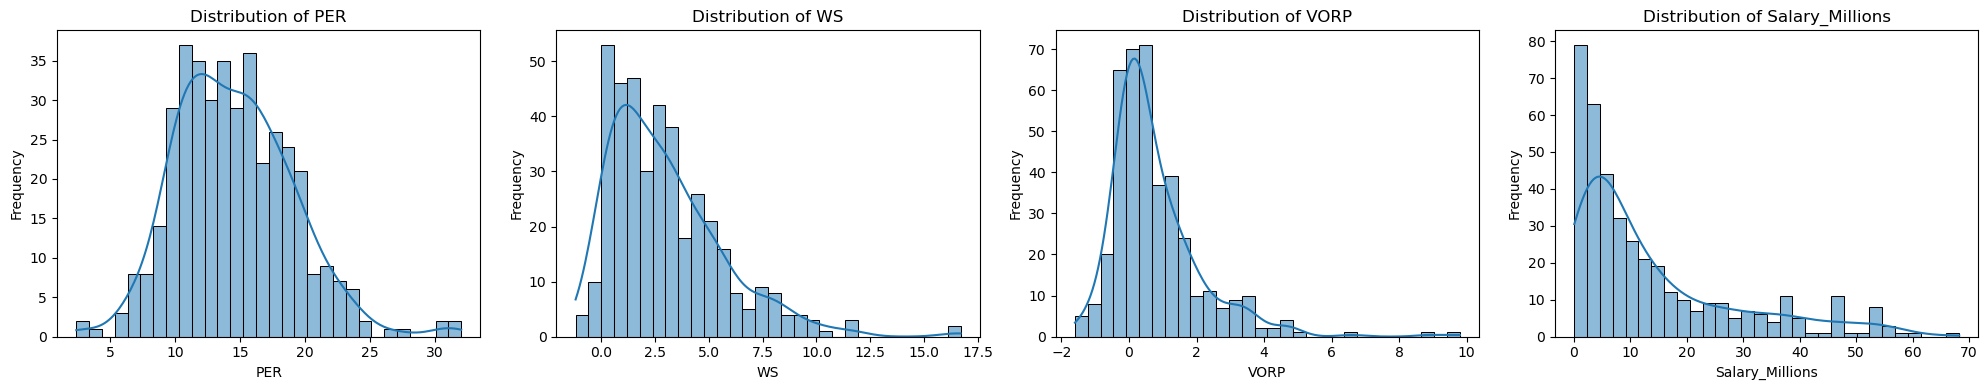

In [18]:
#7 Create histograms of key features
features = ['PER', 'WS', 'VORP', 'Salary_Millions']
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for idx, feature in enumerate(features):
    sns.histplot(df_merged[feature], bins=30, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

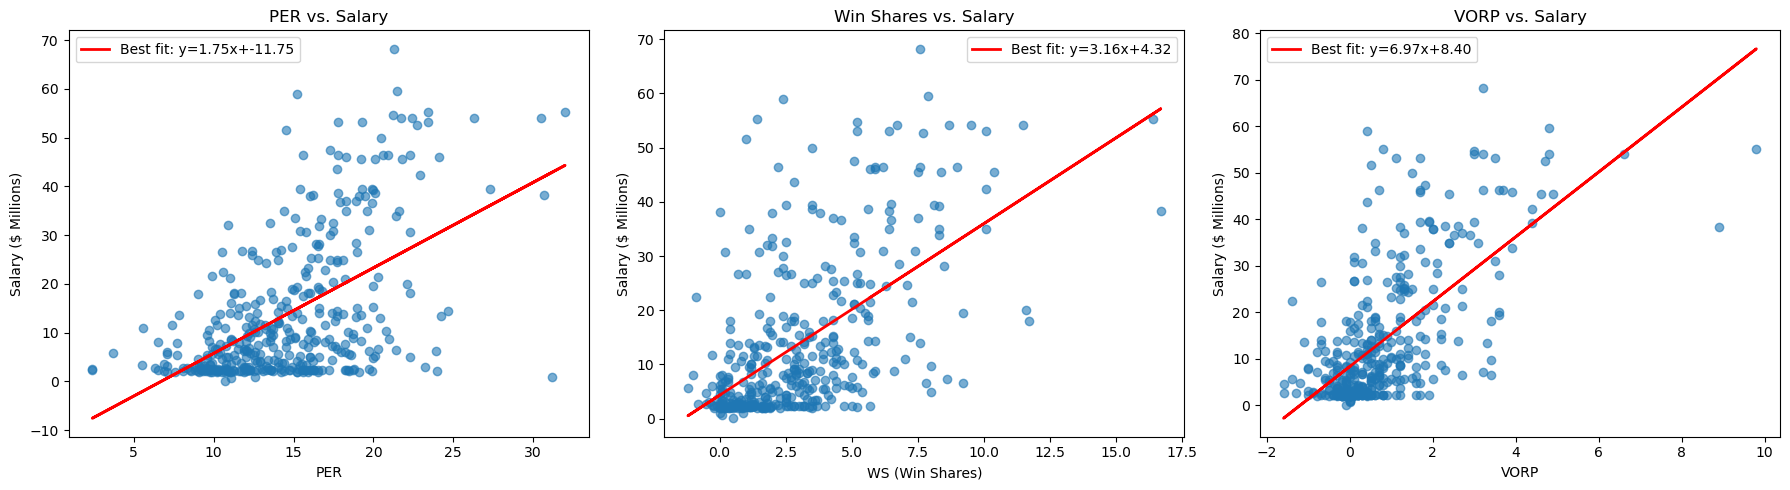

In [19]:
#8 scatter plot of PER, WS and VORP vs. Salary with best fit lines 

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Function to add best fit line
def add_best_fit(ax, x, y):
    # Remove any NaN values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_clean = x[mask]
    y_clean = y[mask]
    
    # Calculate best fit line
    z = np.polyfit(x_clean, y_clean, 1)
    p = np.poly1d(z)
    
    # Add line to plot
    ax.plot(x_clean, p(x_clean), "r-", linewidth=2, label=f'Best fit: y={z[0]:.2f}x+{z[1]:.2f}')
    ax.legend()

# Scatter plot 1: PER vs. Salary
axes[0].scatter(df_merged['PER'], df_merged['Salary_Millions'], alpha=0.6)
add_best_fit(axes[0], df_merged['PER'].values, df_merged['Salary_Millions'].values)
axes[0].set_xlabel('PER')
axes[0].set_ylabel('Salary ($ Millions)')
axes[0].set_title('PER vs. Salary')

# Scatter plot 2: WS vs. Salary
axes[1].scatter(df_merged['WS'], df_merged['Salary_Millions'], alpha=0.6)
add_best_fit(axes[1], df_merged['WS'].values, df_merged['Salary_Millions'].values)
axes[1].set_xlabel('WS (Win Shares)')
axes[1].set_ylabel('Salary ($ Millions)')
axes[1].set_title('Win Shares vs. Salary')

# Scatter plot 3: VORP vs. Salary
axes[2].scatter(df_merged['VORP'], df_merged['Salary_Millions'], alpha=0.6)
add_best_fit(axes[2], df_merged['VORP'].values, df_merged['Salary_Millions'].values)
axes[2].set_xlabel('VORP')
axes[2].set_ylabel('Salary ($ Millions)')
axes[2].set_title('VORP vs. Salary')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

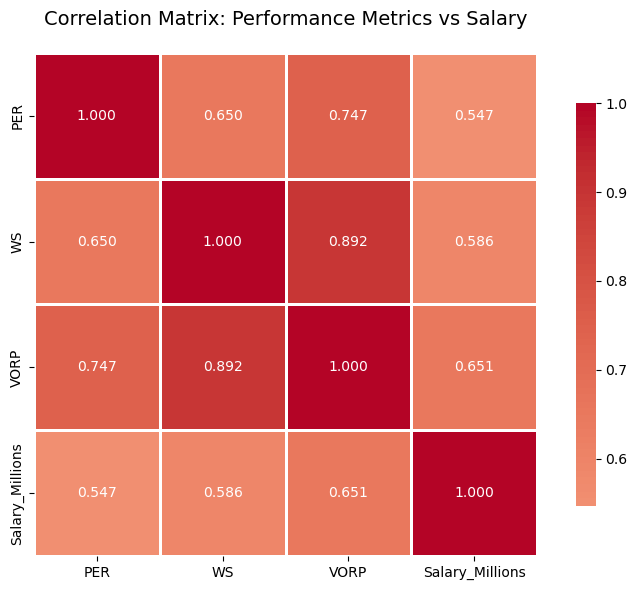

In [20]:
#9 Create correlation matrix for PER, WS, VORP, and Salary
correlation_matrix = df_merged[['PER', 'WS', 'VORP', 'Salary_Millions']].corr()

# Create a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            fmt='.3f',   # Format to 3 decimal places
            cmap='coolwarm',  # Color scheme
            center=0,    # Center colormap at 0
            square=True,  # Make cells square
            linewidths=1,  # Add gridlines
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Performance Metrics vs Salary', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


Training Set:
  R² Score: 0.6459
  RMSE: $8.80M
  MAE: $6.57M

Test Set:
  R² Score: 0.5276
  RMSE: $8.94M
  MAE: $6.76M


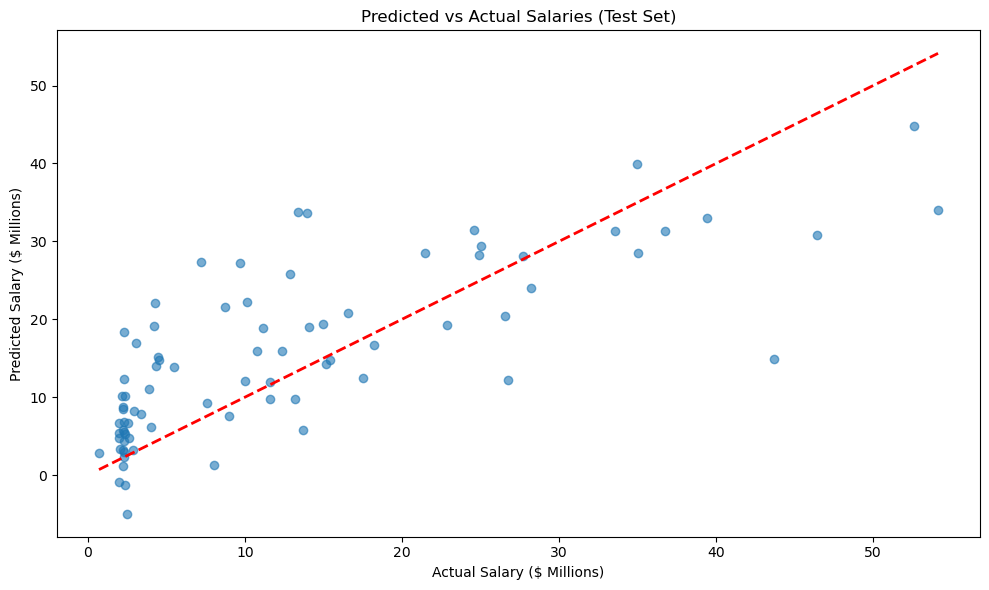

In [21]:
#10 create a multi-linear regression analysis to predict salaries

# Select features for the model (all numeric columns except salary columns)
features_to_use = ['PER', 'TS%', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 
                   'MP', 'G', 'USG%', 'AST%', 'TRB%']

# Remove rows with missing values in the features we're using
df_model = df_merged[features_to_use + ['Salary_Millions']].dropna()

# Separate features (X) and target variable (y)
X = df_model[features_to_use]
y = df_model['Salary_Millions']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
print(f"\nTraining Set:")
print(f"  R² Score: {r2_score(y_train, y_pred_train):.4f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}M")
print(f"  MAE: ${mean_absolute_error(y_train, y_pred_train):.2f}M")

print(f"\nTest Set:")
print(f"  R² Score: {r2_score(y_test, y_pred_test):.4f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}M")
print(f"  MAE: ${mean_absolute_error(y_test, y_pred_test):.2f}M")

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salary ($ Millions)')
plt.ylabel('Predicted Salary ($ Millions)')
plt.title('Predicted vs Actual Salaries (Test Set)')
plt.tight_layout()
plt.show()

In [22]:
#11 Create a dataframe with actual vs predicted salaries
# Get the player names and age from the original df_merged using the index
player_names = df_merged.loc[X_test.index, 'Player']
player_ages = df_merged.loc[X_test.index, 'Age']

results_df = pd.DataFrame({
    'Player': player_names.values,
    'Age': player_ages.values,
    'Actual_Salary_Millions': y_test.values,
    'Predicted_Salary_Millions': y_pred_test,
    'Difference_Millions': y_test.values - y_pred_test
})

# Sort by difference to identify overpaid and underpaid players
results_df = results_df.sort_values('Difference_Millions', ascending=False)

print("==" * 40)
print("TOP 3 OVERPAID PLAYERS (Actual > Predicted)")
print("==" * 40)
print(results_df.head(3)[['Player', 'Age', 'Actual_Salary_Millions', 
                          'Predicted_Salary_Millions', 'Difference_Millions']].to_string(index=False))

print("\n" + "==" * 40)
print("TOP 3 UNDERPAID PLAYERS (Predicted > Actual)")
print("==" * 40)
print(results_df.tail(3)[['Player', 'Age', 'Actual_Salary_Millions', 
                          'Predicted_Salary_Millions', 'Difference_Millions']].to_string(index=False))

# Optionally save to CSV
results_df.to_csv('salary_predictions.csv', index=False)
print("\nFull results saved to 'salary_predictions.csv'")

TOP 3 OVERPAID PLAYERS (Actual > Predicted)
       Player  Age  Actual_Salary_Millions  Predicted_Salary_Millions  Difference_Millions
Deandre Ayton 26.0               43.654814                  14.865240            28.789574
Anthony Davis 31.0               54.126450                  33.962033            20.164417
 Jamal Murray 27.0               46.394100                  30.837611            15.556489

TOP 3 UNDERPAID PLAYERS (Predicted > Actual)
           Player  Age  Actual_Salary_Millions  Predicted_Salary_Millions  Difference_Millions
    Austin Reaves 26.0               13.937574                  33.614762           -19.677188
 Payton Pritchard 27.0                7.232143                  27.357147           -20.125004
Victor Wembanyama 21.0               13.376880                  33.729421           -20.352541

Full results saved to 'salary_predictions.csv'
